## True Rosenbrock Posterior Calculation Using Emcee 

---

David P. Fleming, 2019

This notebook demonstrates how to use the Metropolis-Hastings MCMC algorithm to derive the posterior distribution for the Rosenbrock function example presented in Wang & Li (2017) using emcee.

See https://emcee.readthedocs.io/en/stable/ for more information on emcee.

In [2]:
%matplotlib inline

from approxposterior import likelihood as lh
from approxposterior import mcmcUtils

import numpy as np
import emcee
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 18})

/Users/dflemin3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
np.random.seed(42)

**Set up MCMC initial conditions**

---

In [4]:
ndim = 2          # Number of dimensions
nsteps = 20000    # Number of MCMC iterations

nwalk = 20 * ndim # Use 20 walkers per dimension

# Initial guess for walkers (random over prior)
p0 = [lh.rosenbrockSample(1) for j in range(nwalk)]

**Initialize MCMC Ensemble Sampler object**

---

Note that here, we use the ```lh.rosenbrock_lnprob``` function that computes the log-likelihood plus the log-prior for the Rosenbrock function model as described in Wang & Li (2017).  The functions used to compute this example is provided in ```approxposterior```. See ```example.py``` in ```approxposterior```'s ```examples``` directory for to see how ```approxposterior```'s BAPE algorithm approximates the Rosenbrock function posterior derived in this notebook.

In [5]:
sampler = emcee.EnsembleSampler(nwalk, ndim, lh.rosenbrockLnprob)

**Run the MCMC!**

---

After the MCMC run finishes, we estimate the burn in following the example in the emcee documentation.

In [6]:
sampler.run_mcmc(p0, nsteps)
print("emcee finished!")

emcee finished!


In [7]:
iburn = int(2.0*np.max(sampler.get_autocorr_time(tol=0)))
print(iburn)

262


**Let's visually inspect the chains to see if they're converged.**

---

The blue dashed line corresponds to our burn in estimate.

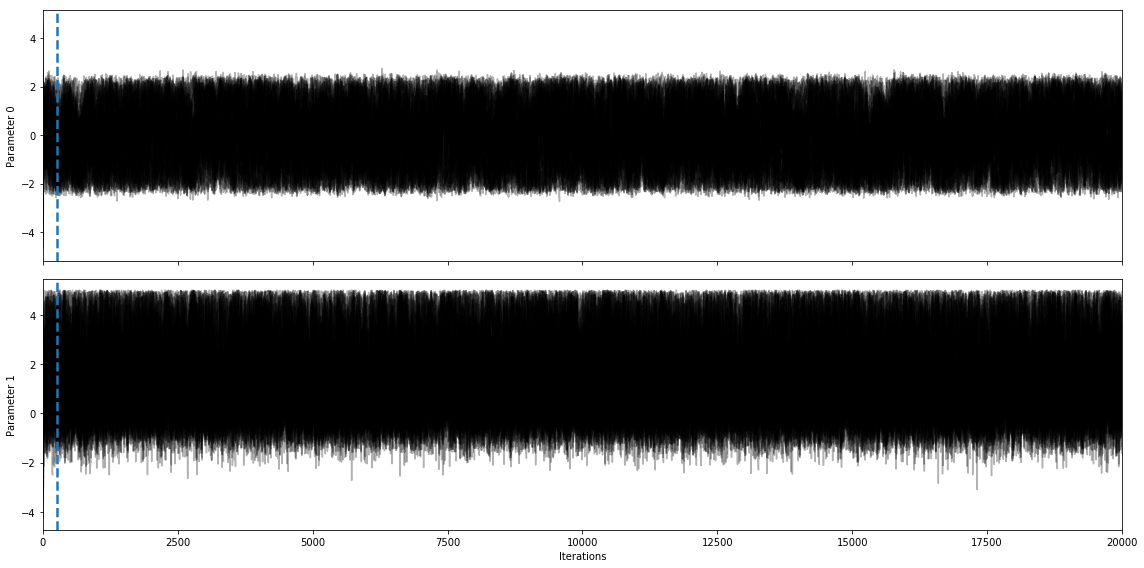

In [8]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(16,8))

# Plot allllll the walkers and chains
ax[0].plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3);
ax[1].plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3);

# Plot where the burn in is
ax[0].axvline(iburn, ls="--", color="C0", lw=2.5)
ax[1].axvline(iburn, ls="--", color="C0", lw=2.5)

# Formatting
ax[0].set_xlim(0,nsteps)
ax[1].set_xlim(0,nsteps)
ax[0].set_ylabel("Parameter 0")
ax[1].set_ylabel("Parameter 1")
ax[1].set_xlabel("Iterations")

fig.tight_layout()

**Looks good!  Let's plot the joint and marginal posterior distributions.**

---

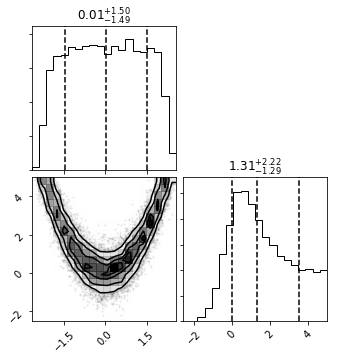

In [9]:
fig = corner.corner(sampler.get_chain(discard=iburn, flat=True, thin=int(iburn/4.0)),
                    quantiles=[0.16, 0.5, 0.84],
                    plot_contours=True, show_titles=True);

fig.savefig("true_post.pdf", bbox_inches="tight")

Neat.  Now let's save the sampler object and burn in time into a numpy archive so we can compare our approximate distributions with the truth derived here to see how accurate ```approxposterior``` (in another notebook...)!

In [10]:
np.savez("trueRosenbrock.npz", 
         flatchain=sampler.flatchain,
         iburn=iburn)